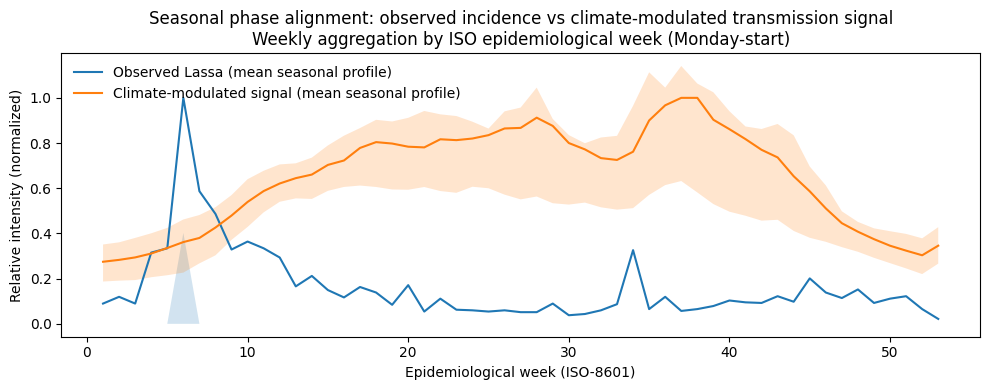

[saved] /Users/emmanuelbenyeogor/Projects/lassa-transmission-pipeline/reports/figures/fig_validation_seasonal_phase_alignment.png


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Paths
# -----------------------------
OUTDIR = Path("../reports/figures")   # repo-level from notebooks/
OUTDIR.mkdir(parents=True, exist_ok=True)
FIG_NAME = "fig_validation_seasonal_phase_alignment.png"

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("../data/processed/model/lassa_era5_weekly_panel_2018_2021.csv")

# First check ONLY the columns that exist in your file
required_raw = {"state", "year", "week", "cases", "rain_mm", "temp_c"}
missing_raw = required_raw - set(df.columns)
if missing_raw:
    raise ValueError(f"Missing required RAW columns: {missing_raw}")

# -----------------------------
# Construct climate-modulated transmission signal (proxy)
# -----------------------------
df = df.copy()

# Standardize climate variables globally (z-scores)
df["rain_z"] = (df["rain_mm"] - df["rain_mm"].mean()) / df["rain_mm"].std(ddof=0)
df["temp_z"] = (df["temp_c"] - df["temp_c"].mean()) / df["temp_c"].std(ddof=0)

# Simple forcing function (illustrative weights; not fitted)
df["seir_climate"] = 0.6 * df["rain_z"] + 0.4 * df["temp_z"]

# Positive relative intensity
df["seir_climate"] = np.exp(df["seir_climate"])

# Smooth within state to reflect latent eco/epi processes (optional but reasonable)
df = df.sort_values(["state", "year", "week"])
df["seir_climate"] = (
    df.groupby("state")["seir_climate"]
      .transform(lambda x: x.rolling(4, min_periods=1).mean())
)

# Now verify the columns needed for the seasonal validation
required = {"year", "week", "cases", "seir_climate"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Still missing required columns after construction: {missing}")

# -----------------------------
# Aggregate seasonal profiles (by epidemiological week across years)
# -----------------------------
seasonal = (
    df.groupby("week")
      .agg(
          obs_mean=("cases", "mean"),
          obs_lo=("cases", lambda x: np.percentile(x, 25)),
          obs_hi=("cases", lambda x: np.percentile(x, 75)),
          seir_mean=("seir_climate", "mean"),
          seir_lo=("seir_climate", lambda x: np.percentile(x, 25)),
          seir_hi=("seir_climate", lambda x: np.percentile(x, 75)),
      )
      .reset_index()
      .sort_values("week")
)

# Normalize to compare SHAPE / PHASE only (not magnitude)
obs_scale = seasonal["obs_mean"].max() if seasonal["obs_mean"].max() > 0 else 1.0
seir_scale = seasonal["seir_mean"].max() if seasonal["seir_mean"].max() > 0 else 1.0

seasonal["obs_mean_norm"] = seasonal["obs_mean"] / obs_scale
seasonal["obs_lo_norm"]   = seasonal["obs_lo"] / obs_scale
seasonal["obs_hi_norm"]   = seasonal["obs_hi"] / obs_scale

seasonal["seir_mean_norm"] = seasonal["seir_mean"] / seir_scale
seasonal["seir_lo_norm"]   = seasonal["seir_lo"] / seir_scale
seasonal["seir_hi_norm"]   = seasonal["seir_hi"] / seir_scale

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 4))

plt.plot(seasonal["week"], seasonal["obs_mean_norm"], label="Observed Lassa (mean seasonal profile)")
plt.fill_between(seasonal["week"], seasonal["obs_lo_norm"], seasonal["obs_hi_norm"], alpha=0.2)

plt.plot(seasonal["week"], seasonal["seir_mean_norm"], label="Climate-modulated signal (mean seasonal profile)")
plt.fill_between(seasonal["week"], seasonal["seir_lo_norm"], seasonal["seir_hi_norm"], alpha=0.2)

plt.xlabel("Epidemiological week (ISO-8601)")
plt.ylabel("Relative intensity (normalized)")
plt.title(
    "Seasonal phase alignment: observed incidence vs climate-modulated transmission signal\n"
    "Weekly aggregation by ISO epidemiological week (Monday-start)"
)
plt.legend(frameon=False)
plt.tight_layout()

outpath = OUTDIR / FIG_NAME
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print(f"[saved] {outpath.resolve()}")
